In [54]:
import torch
from torch.utils.data import Dataset
from utils import files2dfs_maps, df_convert_date2timestamp
from bags2csvs import bag2df, bags2dfs

import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.pipeline
import sklearn.dummy
import sklearn.preprocessing
import sklearn.metrics.regression
from sklearn.metrics import auc, roc_curve
import skimage.transform


In [4]:
DATASET_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/bag/'

csv_paths = glob.glob(DATASET_FOLDER + '/flat/*.bag')
print(csv_paths)
data = bags2dfs(csv_paths)[0]

['/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573200.115245.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573220.5950947.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573239.7535734.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573259.413545.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573279.9246588.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573300.419159.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573320.6889715.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573339.5792696.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573358.0218253.bag', '/home/francesco/Desktop/carino/vaevictis/data/bag//flat/1542573378.4530427.bag']


In [26]:
df.columns[-1:] + df.columns[:-1]

Index(['datepose__pose_position_x', 'datepose__pose_position_y',
       'datepose__pose_position_z', 'datepose__pose_orientation_x',
       'datepose__pose_orientation_y', 'datepose__pose_orientation_z',
       'datepose__pose_orientation_w'],
      dtype='object')

In [68]:
DATASET_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/csv/'

csv_paths = glob.glob(DATASET_FOLDER + '/flat/*.csv')

df = pd.read_csv(csv_paths[0])

df = df_convert_date2timestamp(df)

def get_pose(row):
    return (row['pose__pose_position_x'], row['pose__pose_position_y'])

dists = []
vels = []

for i in range(1, len(df)):
    p1 = get_pose(df.iloc[i-1])
    p2 = get_pose(df.iloc[i])
    
    t1 = df.iloc[i - 1]['Unnamed: 0']
    t2 = df.iloc[i]['Unnamed: 0']
    
    dist = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
    vel = dist/ (t2 - t1)
    
    dists.append(dist)
    vels.append(vel)

dists.append(None)
vels.append(None)

df['distance'] = dists
df['velocity'] = dists

df['velocity'].max(), df['velocity'].min(), df['velocity'].mean()

(0.0019967410100018694, 6.80115369527033e-07, 0.0012452060928795285)

In [133]:
tot = 0
for df, _, _ in data:
#     df, _, _ = data[1]
    df

    x1 = df['pose__pose_position_x'].values

    x2 = np.roll(x1, -100) 

    x1 = np.delete(x1, x1.shape[0] - 1)
    x2 = np.delete(x2, x1.shape[0] - 1)
    
    speed = (x2 - x1).mean() *100
    tot += speed
    
tot / len(data)

0.06199238645897677

In [87]:
x = np.array([1,2,3])

np.delete(x, x.shape[0] - 1), np.delete(np.roll(x, -1), x.shape[0] - 1) 

(array([1, 2]), array([2, 3]))

In [136]:
DATASET_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/dataset/'
MAPS_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/maps/'

csv_paths = glob.glob(DATASET_FOLDER + '/*/**.csv')

In [143]:
import torch
from torch.utils.data import Dataset
from utils.postprocessing.utils import files2dfs_maps
import numpy as np
import glob

import sklearn.pipeline
import sklearn.dummy
import sklearn.preprocessing
import sklearn.metrics.regression
from sklearn.metrics import auc, roc_curve
import skimage.transform


class TraversabilityDataset(Dataset):
    def __init__(self, data, patch_size=80):
        self.data = data
        self.patch_size = patch_size
        self.inputs = []
        self.targets = []

        for df, hm in self.data:
            if len(df) == 0: continue
            im, l = self.sample(df, hm, patch_size)
            self.inputs.append(im[:, :, np.newaxis])
            self.targets.append(l)

        self.inputs = np.array( self.inputs).astype('float32')
        self.targets = np.array(self.targets).astype('int')

    def sample(self, df, hm, sz):
        d = df.sample(1)
        l = d["label"].iloc[0]
        # hm = hms[d["hm"].iloc[0]]
        patch = self.hmpatch(hm, d["hm_x"].iloc[0], d["hm_y"].iloc[0], np.rad2deg(d["pose__pose_e_orientation_z"].iloc[0]),
                     self.patch_size, scale=1)[0]
        patch = self.transform_patch(patch, sz)
        return patch, l

    def hmpatch(self, hm, x, y, alpha, edge, scale=1):
        # Cutout a patch from the image, centered on (x,y), rotated by alpha
        # degrees (0 means bottom in hm remains bottom in patch, 90 means bottom in hm becomes right in patch),
        # with a specified edge size (in pixels) and scale (relative).
        tf1 = skimage.transform.SimilarityTransform(translation=[-x, -y])
        tf2 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(alpha))
        tf3 = skimage.transform.SimilarityTransform(scale=scale)
        tf4 = skimage.transform.SimilarityTransform(translation=[+edge / 2, +edge / 2])
        tf = (tf1 + (tf2 + (tf3 + tf4))).inverse
        # corners=tf(np.array([[0,0],[1,0],[1,1],[0,1]])*edge)
        corners = tf(np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]]) * edge)
        patch = skimage.transform.warp(hm, tf, output_shape=(edge, edge), mode="edge")
        return patch, corners

    def transform_patch(self, patch, sz):
        t_patch = patch - patch[patch.shape[0] // 2, patch.shape[1] // 2]
        t_patch = skimage.transform.resize(t_patch, (self.patch_size, self.patch_size), mode='constant')
        return t_patch

    def __getitem__(self, item):

        return self.inputs[item], self.targets[item]

    def __len__(self):
        return len(self.targets)

DATASET_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/dataset/'
MAPS_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/maps/'

csv_paths = glob.glob(DATASET_FOLDER + '/flat/*.csv')


In [144]:
csv_paths

['/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573200.115245.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573220.5950947.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573239.7535734.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573259.413545.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573279.9246588.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573300.419159.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573320.6889715.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573339.5792696.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573358.0218253.csv',
 '/home/francesco/Desktop/carino/vaevictis/data/dataset//flat/1542573378.4530427.csv']

In [145]:
dfs_maps = files2dfs_maps(csv_paths)
print(len(dfs_maps))

10


In [146]:
ds = TraversabilityDataset(dfs_maps)
print(len(ds))

10


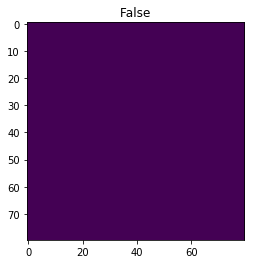

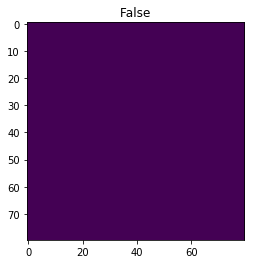

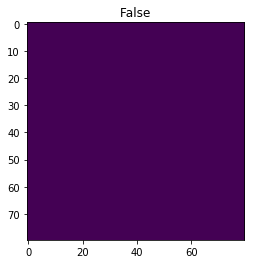

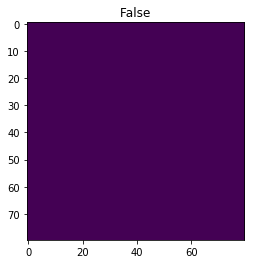

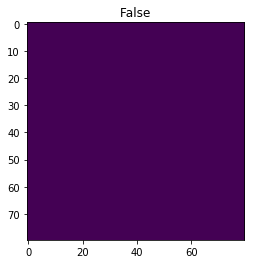

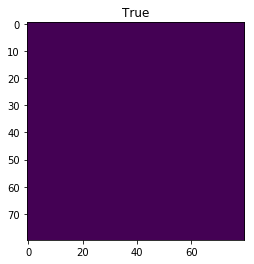

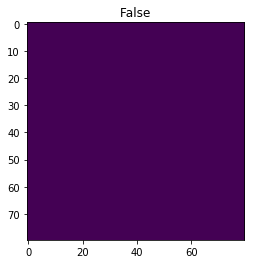

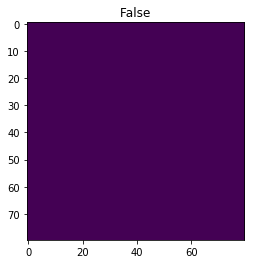

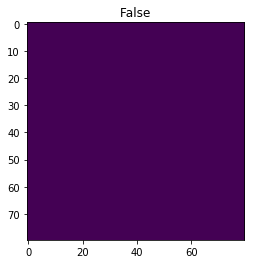

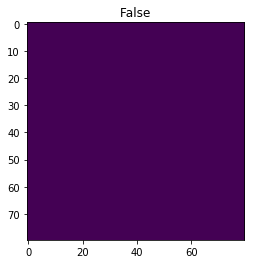

In [147]:

for i in range(10):
    x, y = ds[i]

    plt.title(bool(y))
    plt.imshow(x.squeeze())
    plt.show()


In [2]:
import pandas as pd
import numpy as np

In [5]:
df = pd.DataFrame({'x': np.arange(0,100), 'y': np.arange(0,100)})

In [11]:
df.shift(-2)

,x,y
0,2.0,2.0
1,3.0,3.0
2,4.0,4.0
3,5.0,5.0
4,6.0,6.0
5,7.0,7.0
6,8.0,8.0
7,9.0,9.0
8,10.0,10.0
9,11.0,11.0
